In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# params for graphs 
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2, palette="deep")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [29]:
class FinancialEDA:
    def __init__(self, raw_data_path='data/raw'):
        self.raw_data_path = raw_data_path
        self.yahoo_data_path = os.path.join(self.raw_data_path, 'yahoo')
        self.alpha_vantage_data_path = os.path.join(self.raw_data_path, 'alpha_vantage')
        self.fred_data_path = os.path.join(self.raw_data_path, 'fred')
        self.crypto_data_path = os.path.join(self.raw_data_path, 'crypto')
        self.reits_data_path = os.path.join(self.raw_data_path, 'reits')
        
        self.stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
        self.etfs = ['SPY', 'QQQ', 'XLK', 'XLV', 'XLF']
        self.indices = ['^GSPC', '^IXIC', '^DJI', '^RUT']
        self.bonds = ['^TNX', 'IEF', 'TLT']
        self.commodities = ['GC=F', 'CL=F', 'SI=F']
        self.reits = ['VNQ', 'SCHH', 'IYR']
        self.cryptos = ['BTC', 'ETH', 'LTC']
        self.economic_indicators = {
            'CPI': 'CPIAUCSL',
            'FEDFUNDS': 'FEDFUNDS',
            'UNRATE': 'UNRATE',
            'PPI': 'PPIACO'
        }
        
        self.all_assets = self.stocks + self.etfs + self.indices + self.bonds + self.commodities + self.reits + self.cryptos
        self.asset_data = {}
        self.load_data()

    def load_data(self):
        for asset in self.all_assets:
            if asset in self.cryptos:
                file_path = os.path.join(self.crypto_data_path, f"{asset}.csv")
            elif asset in self.reits:
                file_path = os.path.join(self.reits_data_path, f"{asset}.csv")
            else:
                file_path = os.path.join(self.yahoo_data_path, f"{asset}.csv")
            
            if os.path.exists(file_path):
                df = pd.read_csv(file_path, parse_dates=[0])
                df.sort_values(df.columns[0], inplace=True)
                if asset in self.cryptos:
                    df.rename(columns={df.columns[0]: 'Date', df.columns[4]: 'Close'}, inplace=True)
                elif 'Close' not in df.columns and 'close' in df.columns:
                    df.rename(columns={'close': 'Close'}, inplace=True)
                self.asset_data[asset] = df
                print(f"Loaded data for {asset}")
            else:
                print(f"File not found: {file_path}")
        
        # economic indicators
        for indicator, series_id in self.economic_indicators.items():
            file_path = os.path.join(self.fred_data_path, f"{series_id}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path, parse_dates=[0], index_col=0)
                df.rename(columns={df.columns[0]: indicator}, inplace=True)
                self.asset_data[indicator] = df
                print(f"Loaded data for {indicator}")
            else:
                print(f"File not found: {file_path}")

    """general function to plot prices over time"""
    def plot_prices_over_time(self, assets, title):
        plt.figure(figsize=(14, 7))
        for asset in assets:
            if asset in self.asset_data:
                df = self.asset_data[asset]
                if 'Close' in df.columns:
                    df_clean = df.dropna(subset=['Date', 'Close']).reset_index(drop=True)
                    
                    # ensure'Date' and 'Close' are sorted and aligned
                    df_clean.sort_values(by='Date', inplace=True)
                    df_clean.drop_duplicates(subset='Date', keep='last', inplace=True)
                    
                    # debug statements
                    print(f"Asset: {asset}")
                    print(f"Length of Date: {len(df_clean['Date'])}")
                    print(f"Length of Close: {len(df_clean['Close'])}")
                    print(f"First few dates: {df_clean['Date'].head()}")
                    print(f"First few closes: {df_clean['Close'].head()}")
                    
                    if len(df_clean['Date']) == len(df_clean['Close']):
                        plt.plot(df_clean['Date'], df_clean['Close'], label=asset.replace('=F', '').replace('^', ''))
                    else:
                        print(f"Length mismatch for {asset}: Date has {len(df_clean['Date'])} entries, Close has {len(df_clean['Close'])} entries.")
                else:
                    print(f"'Close' column not found for {asset}")
        plt.title(f'Closing {title} Prices Over Time')
        plt.xlabel('Year')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_stock_prices_over_time(self):
        self.plot_prices_over_time(self.stocks, 'Stock')

    def plot_commodity_prices_over_time(self):
        self.plot_prices_over_time(self.commodities, 'Commodity')

    def plot_crypto_prices_over_time(self):
        self.plot_prices_over_time(self.cryptos, 'Cryptocurrency')
    
    """general function to plot annual averages"""
    def plot_annual_average(self, assets, title):
        plt.figure(figsize=(14, 7))
        for asset in assets:
            if asset in self.asset_data:
                df = self.asset_data[asset]
                if 'Close' in df.columns:
                    df['Year'] = df['Date'].dt.year
                    annual_avg = df.groupby('Year')['Close'].mean()
                    plt.plot(annual_avg.index, annual_avg.values, marker='o', label=asset.replace('=F', '').replace('^', ''))
                else:
                    print(f"'Close' column not found for {asset}")
        plt.title(f'Average Annual Closing {title} Prices')
        plt.xlabel('Year')
        plt.ylabel('Average Close Price (USD)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_annual_stock_average(self):
        self.plot_annual_average(self.stocks, 'Stock')

    def plot_annual_commodity_average(self):
        self.plot_annual_average(self.commodities, 'Commodity')

    def plot_annual_crypto_average(self):
        self.plot_annual_average(self.cryptos, 'Cryptocurrency')

    def plot_price_correlations(self, assets, title):
        combined_df = pd.DataFrame({asset.replace('=F', '').replace('^', ''): self.asset_data[asset].set_index('Date')['Close'] 
                                    for asset in assets if asset in self.asset_data and 'Close' in self.asset_data[asset].columns}).dropna()
        correlation = combined_df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'Correlation Matrix of {title} Closing Prices')
        plt.tight_layout()
        plt.show()

    """correlation heatmap for all assets"""
    def plot_stock_price_correlations(self):    
        self.plot_price_correlations(self.stocks, 'Stock')

    def plot_commodity_price_correlations(self):
        self.plot_price_correlations(self.commodities, 'Commodity')

    def plot_crypto_price_correlations(self):
        self.plot_price_correlations(self.cryptos, 'Cryptocurrency')

    def plot_moving_averages(self, window=50):
        """moving averages for all stocks"""
        plt.figure(figsize=(14, 7))
        for stock in self.stocks:
            if stock in self.asset_data:
                df = self.asset_data[stock]
                if 'Close' in df.columns:
                    df['MA'] = df['Close'].rolling(window=window).mean()
                    
                    # drop rows with NaN in 'Date', 'Close', or 'MA'
                    df_clean = df.dropna(subset=['Date', 'Close', 'MA']).reset_index(drop=True)
                    
                    # debug
                    # print(f"Stock: {stock}")
                    # print(f"Length of Date: {len(df_clean['Date'])}")
                    # print(f"Length of Close: {len(df_clean['Close'])}")
                    # print(f"Length of MA: {len(df_clean['MA'])}")
                    
                    if len(df_clean['Date']) == len(df_clean['Close']) == len(df_clean['MA']):
                        plt.plot(df_clean['Date'], df_clean['Close'], label=f"{stock} Close")
                        plt.plot(df_clean['Date'], df_clean['MA'], label=f"{stock} {window}-Day MA")
                    else:
                        print(f"Length mismatch for {stock} after calculating MA.")
                else:
                    print(f"'Close' column not found for {stock}")
        plt.title(f'{window}-Day Moving Averages for Stocks')
        plt.xlabel('Year')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_volume_trends(self):
        plt.figure(figsize=(14, 7))
        for stock in self.stocks:
            if stock in self.asset_data:
                df = self.asset_data[stock]
                if 'Volume' in df.columns:
                    plt.plot(df['Date'], df['Volume'], label=stock)
                else:
                    print(f"'Volume' column not found for {stock}")
        plt.title('Trading Volume Over Time')
        plt.xlabel('Year')
        plt.ylabel('Volume')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_economic_indicators(self):
        plt.figure(figsize=(14, 7))
        for indicator, series_id in self.economic_indicators.items():
            if indicator in self.asset_data:
                df = self.asset_data[indicator]
                plt.plot(df.index, df[indicator], label=indicator)
        plt.title('Economic Indicators Over Time')
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def calculate_rolling_sharpe_ratio(self, asset, risk_free_rate=0.02, window=252):
        if asset in self.asset_data:
            df = self.asset_data[asset]
            if 'Close' in df.columns:
                # daily returns
                returns = df['Close'].pct_change().dropna()
                
                # excess returns
                excess_returns = returns - risk_free_rate / 252
                
                # rolling mean and standard deviation
                rolling_mean = excess_returns.rolling(window=window).mean()
                rolling_std = returns.rolling(window=window).std()
                
                # Sharpe ratio
                sharpe_ratio = (rolling_mean / rolling_std) * np.sqrt(252)
                
                # align dates with Sharpe ratio
                sharpe_ratio = sharpe_ratio.dropna()
                return sharpe_ratio
            else:
                print(f"'Close' column not found for {asset}")
        return None

    def plot_rolling_sharpe_ratios(self, assets, risk_free_rate=0.02, window=252):
        plt.figure(figsize=(14, 7))
        for asset in assets:
            sharpe_ratio = self.calculate_rolling_sharpe_ratio(asset, risk_free_rate, window)
            if sharpe_ratio is not None:
                # align dates with Sharpe ratio
                df = self.asset_data[asset]
                df = df.dropna(subset=['Close']).reset_index(drop=True)
                dates = df['Date'].iloc[sharpe_ratio.index]
                
                # debugging output
                # print(f"Asset: {asset}")
                # print(f"Dates length: {len(dates)}, Sharpe ratio length: {len(sharpe_ratio)}")
                # print(f"First few dates: {dates.head()}")
                # print(f"First few Sharpe ratios: {sharpe_ratio.head()}")

                if len(dates) == len(sharpe_ratio):
                     plt.plot(dates, sharpe_ratio, label=asset)
                else:
                     print(f"Mismatch in dimensions for {asset}. Dates: {len(dates)}, Sharpe ratio: {len(sharpe_ratio)}")
        plt.title(f'Rolling Sharpe Ratio ({window}-day window)')
        plt.xlabel('Date')
        plt.ylabel('Sharpe Ratio')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def calculate_drawdowns(self, asset):
        if asset in self.asset_data:
            df = self.asset_data[asset]
            if 'Close' in df.columns:
                price = df['Close']
                peak = price.cummax()
                drawdown = (price - peak) / peak
                return drawdown
            else:
                print(f"'Close' column not found for {asset}")
        return None

    def plot_drawdowns(self, assets):
        plt.figure(figsize=(14, 7))
        for asset in assets:
            drawdown = self.calculate_drawdowns(asset)
            if drawdown is not None:
                plt.plot(self.asset_data[asset]['Date'], drawdown, label=asset)
        plt.title('Asset Drawdowns Over Time')
        plt.xlabel('Date')
        plt.ylabel('Drawdown')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [30]:
eda = FinancialEDA()

Loaded data for AAPL
Loaded data for MSFT
Loaded data for AMZN
Loaded data for GOOGL
Loaded data for TSLA
Loaded data for SPY
Loaded data for QQQ
Loaded data for XLK
Loaded data for XLV
Loaded data for XLF
Loaded data for ^GSPC
Loaded data for ^IXIC
Loaded data for ^DJI
Loaded data for ^RUT
Loaded data for ^TNX
Loaded data for IEF
Loaded data for TLT
Loaded data for GC=F
Loaded data for CL=F
Loaded data for SI=F
Loaded data for VNQ
Loaded data for SCHH
Loaded data for IYR
Loaded data for BTC
Loaded data for ETH
Loaded data for LTC
Loaded data for CPI
Loaded data for FEDFUNDS
Loaded data for UNRATE
Loaded data for PPI


Asset: AAPL
Length of Date: 3522
Length of Close: 3522
First few dates: 0   2010-01-04
1   2010-01-05
2   2010-01-06
3   2010-01-07
4   2010-01-08
Name: Date, dtype: datetime64[ns]
First few closes: 0    7.643214
1    7.656429
2    7.534643
3    7.520714
4    7.570714
Name: Close, dtype: float64
Asset: MSFT
Length of Date: 3522
Length of Close: 3522
First few dates: 0   2010-01-04
1   2010-01-05
2   2010-01-06
3   2010-01-07
4   2010-01-08
Name: Date, dtype: datetime64[ns]
First few closes: 0    30.950001
1    30.959999
2    30.770000
3    30.450001
4    30.660000
Name: Close, dtype: float64
Asset: AMZN
Length of Date: 3522
Length of Close: 3522
First few dates: 0   2010-01-04
1   2010-01-05
2   2010-01-06
3   2010-01-07
4   2010-01-08
Name: Date, dtype: datetime64[ns]
First few closes: 0    6.6950
1    6.7345
2    6.6125
3    6.5000
4    6.6760
Name: Close, dtype: float64
Asset: GOOGL
Length of Date: 3522
Length of Close: 3522
First few dates: 0   2010-01-04
1   2010-01-05
2   2010-01

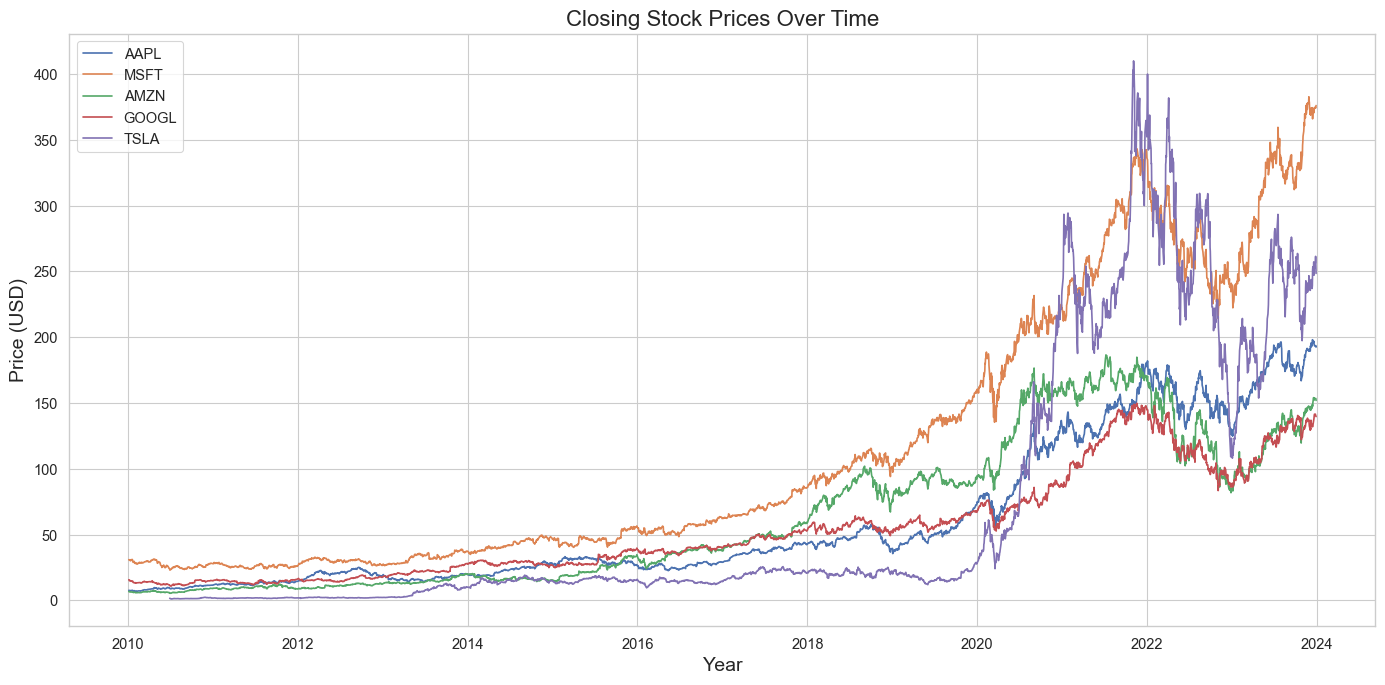

In [31]:
eda.plot_stock_prices_over_time()

Asset: GC=F
Length of Date: 3519
Length of Close: 3519
First few dates: 0   2010-01-04
1   2010-01-05
2   2010-01-06
3   2010-01-07
4   2010-01-08
Name: Date, dtype: datetime64[ns]
First few closes: 0    1117.699951
1    1118.099976
2    1135.900024
3    1133.099976
4    1138.199951
Name: Close, dtype: float64
Asset: CL=F
Length of Date: 3520
Length of Close: 3520
First few dates: 0   2010-01-04
1   2010-01-05
2   2010-01-06
3   2010-01-07
4   2010-01-08
Name: Date, dtype: datetime64[ns]
First few closes: 0    81.510002
1    81.769997
2    83.180000
3    82.660004
4    82.750000
Name: Close, dtype: float64
Asset: SI=F
Length of Date: 3519
Length of Close: 3519
First few dates: 0   2010-01-04
1   2010-01-05
2   2010-01-06
3   2010-01-07
4   2010-01-08
Name: Date, dtype: datetime64[ns]
First few closes: 0    17.440001
1    17.781000
2    18.163000
3    18.333000
4    18.458000
Name: Close, dtype: float64


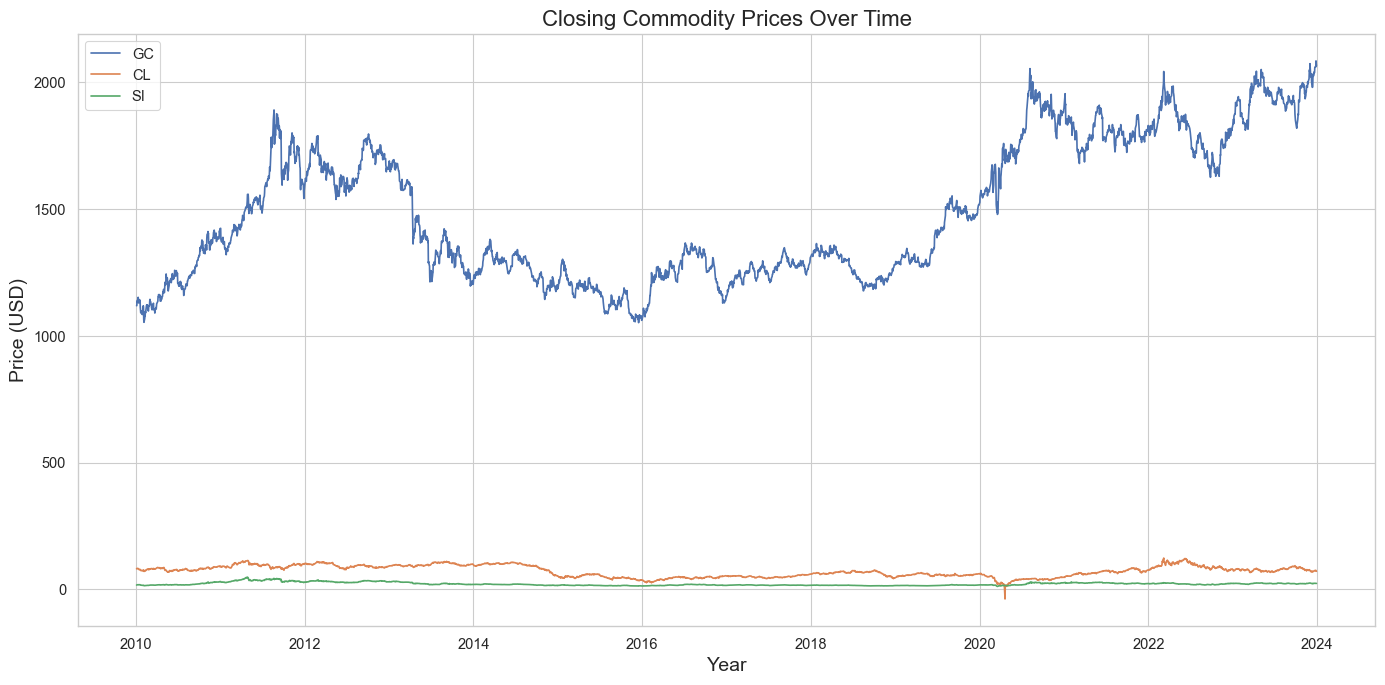

In [32]:

eda.plot_commodity_prices_over_time()

Asset: BTC
Length of Date: 3673
Length of Close: 3673
First few dates: 0   2014-09-17
1   2014-09-18
2   2014-09-19
3   2014-09-20
4   2014-09-21
Name: Date, dtype: datetime64[ns]
First few closes: 0    457.334015
1    424.440002
2    394.795990
3    408.903992
4    398.821014
Name: Close, dtype: float64
Asset: ETH
Length of Date: 2524
Length of Close: 2524
First few dates: 0   2017-11-09
1   2017-11-10
2   2017-11-11
3   2017-11-12
4   2017-11-13
Name: Date, dtype: datetime64[ns]
First few closes: 0    320.884003
1    299.252991
2    314.681000
3    307.907990
4    316.716003
Name: Close, dtype: float64
Asset: LTC
Length of Date: 3673
Length of Close: 3673
First few dates: 0   2014-09-17
1   2014-09-18
2   2014-09-19
3   2014-09-20
4   2014-09-21
Name: Date, dtype: datetime64[ns]
First few closes: 0    5.05855
1    4.68523
2    4.32777
3    4.28644
4    4.24592
Name: Close, dtype: float64


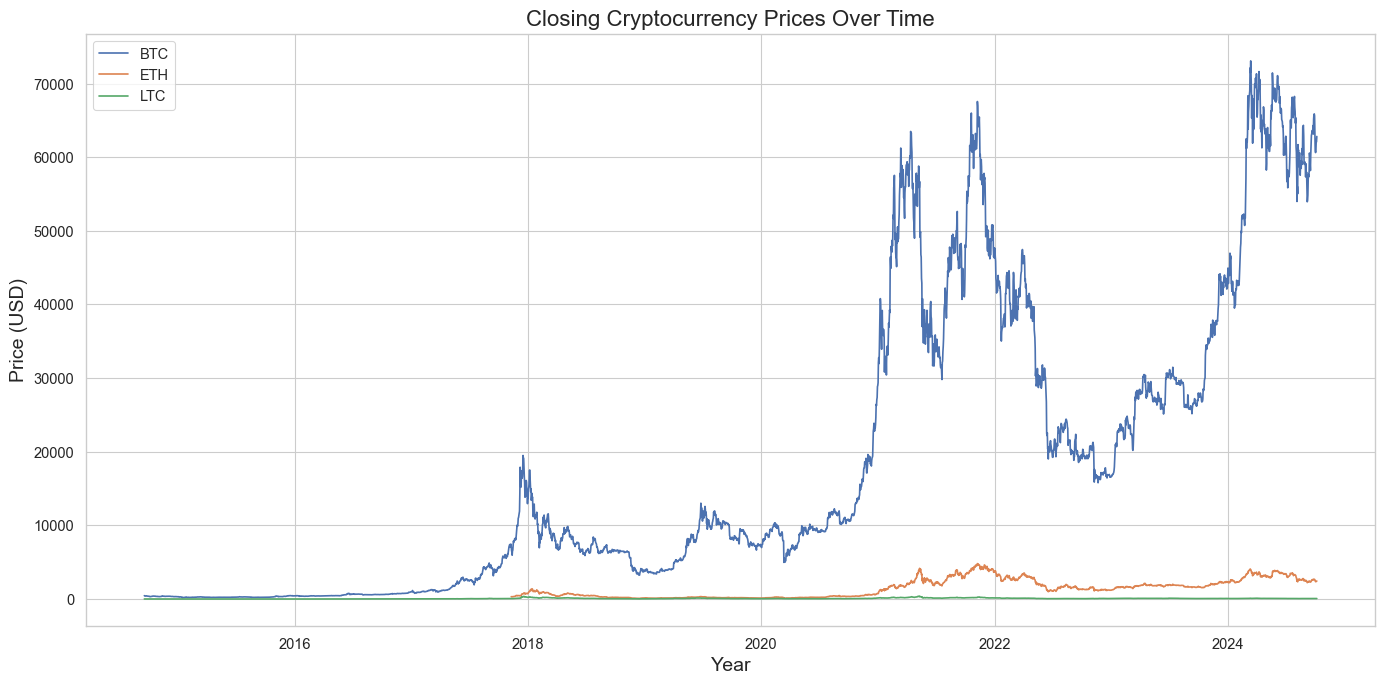

In [33]:

eda.plot_crypto_prices_over_time()

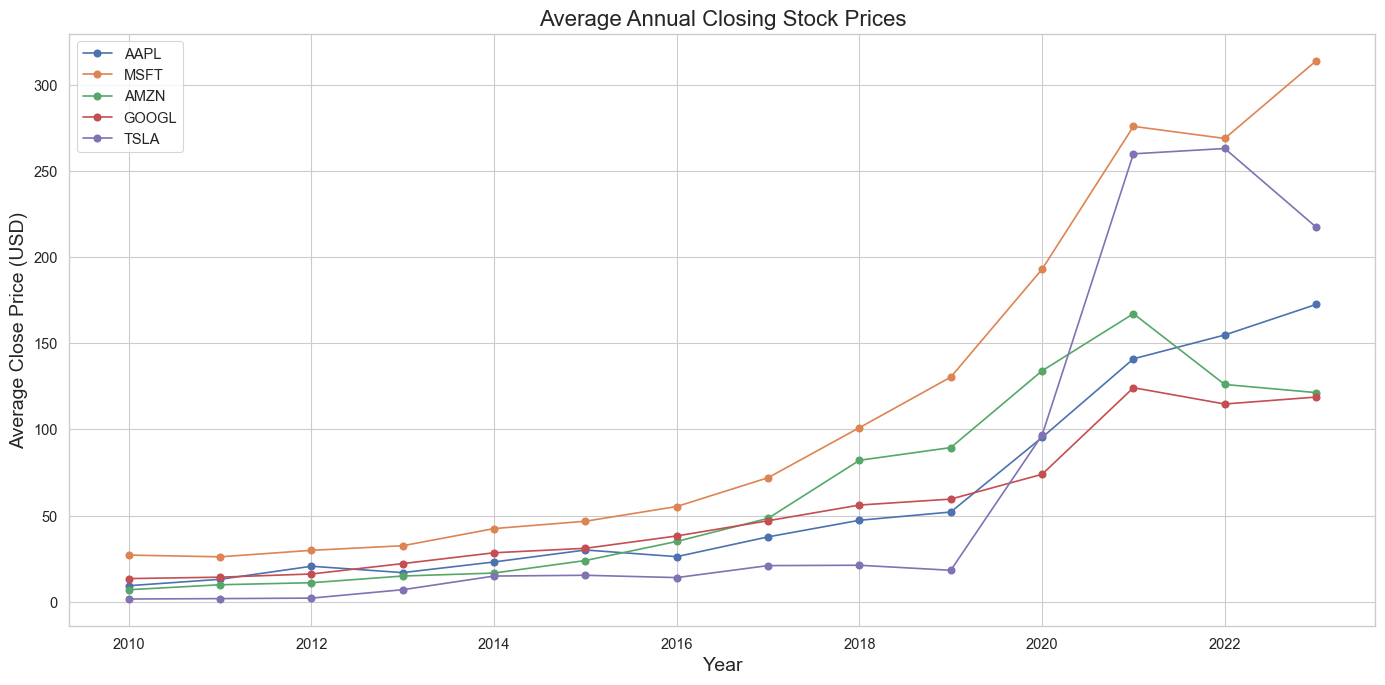

In [34]:
eda.plot_annual_stock_average()

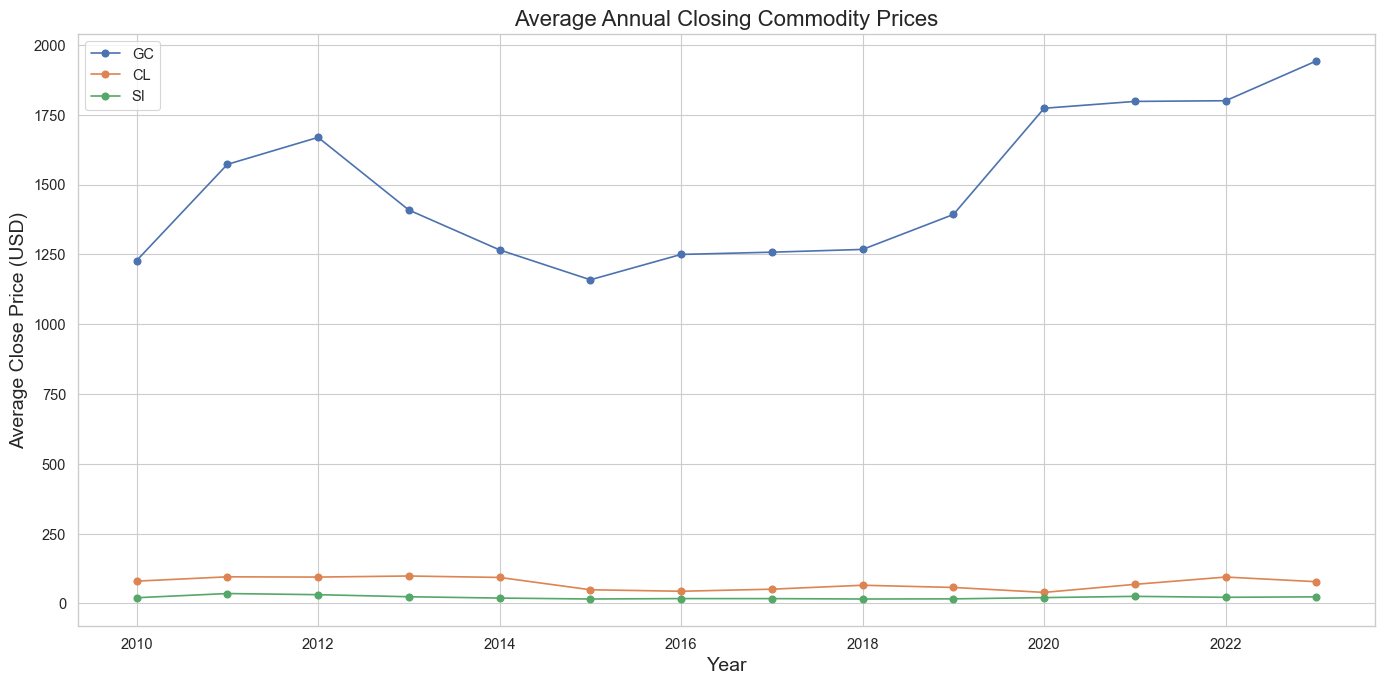

In [35]:
eda.plot_annual_commodity_average()

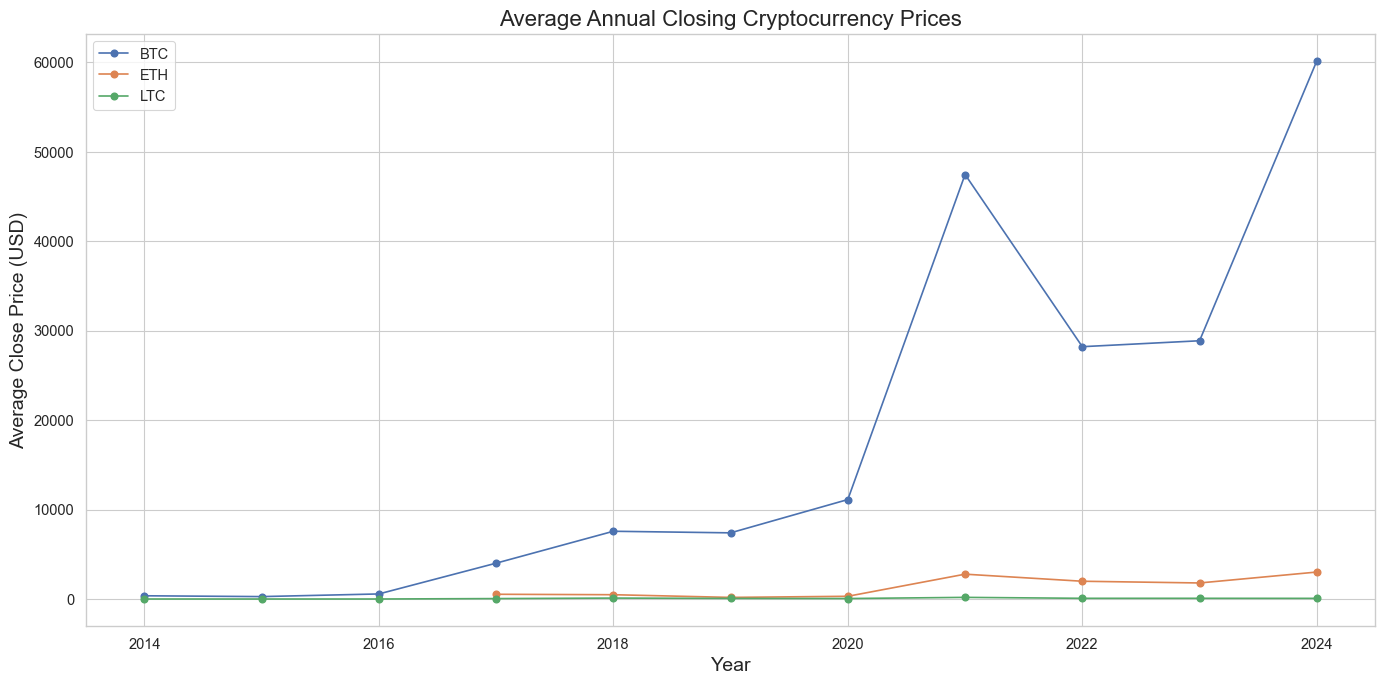

In [36]:
eda.plot_annual_crypto_average()

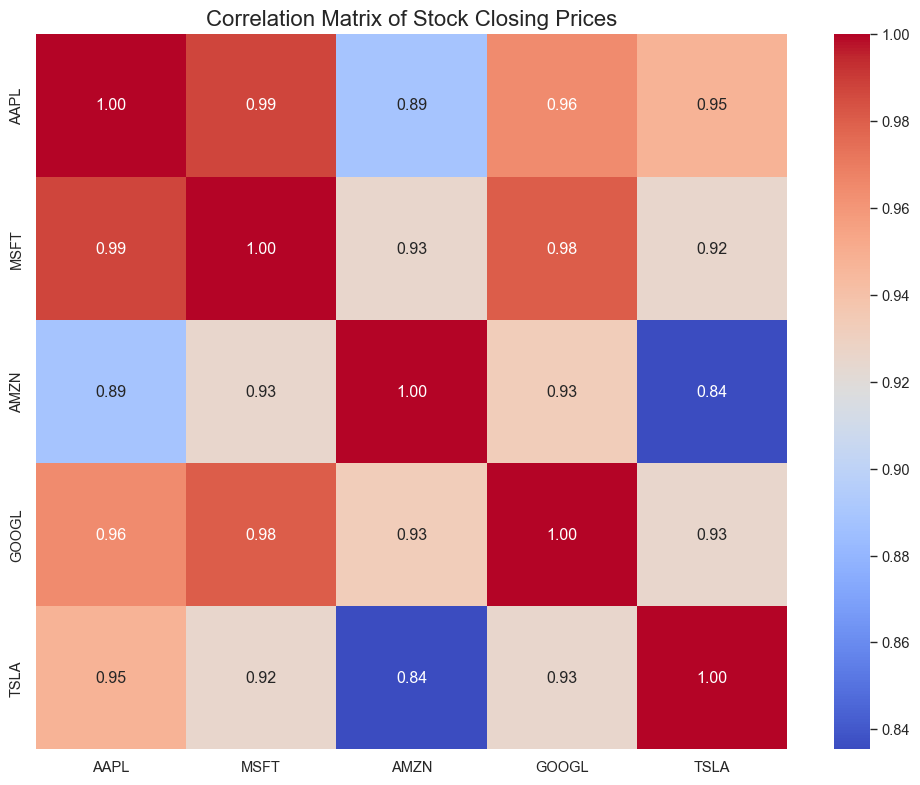

In [37]:
eda.plot_stock_price_correlations()

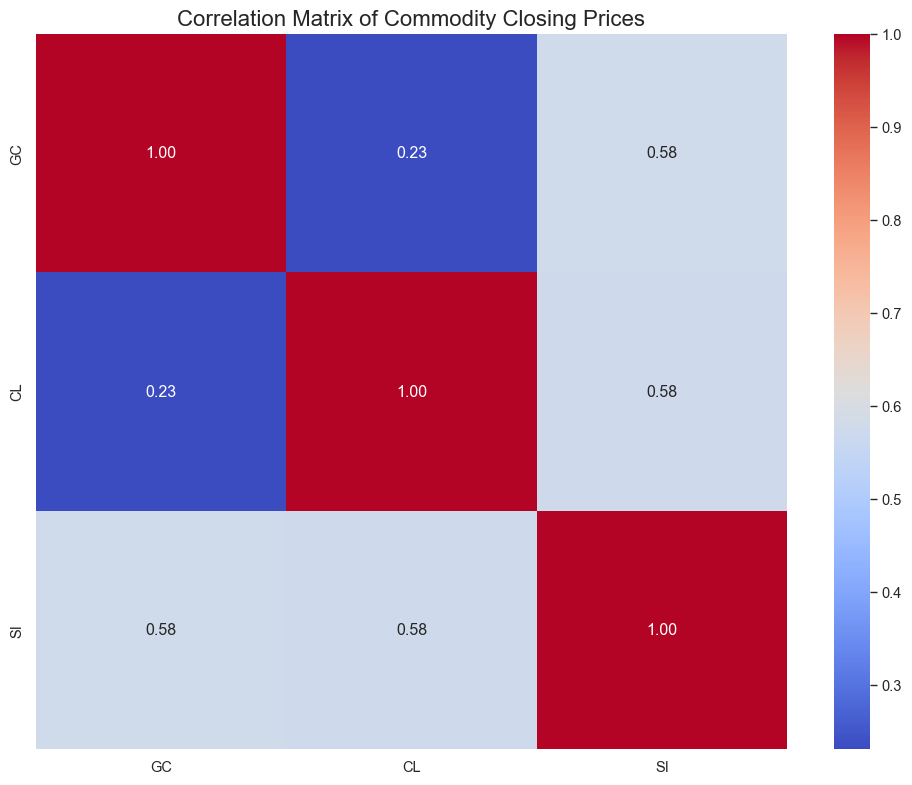

In [38]:
eda.plot_commodity_price_correlations()

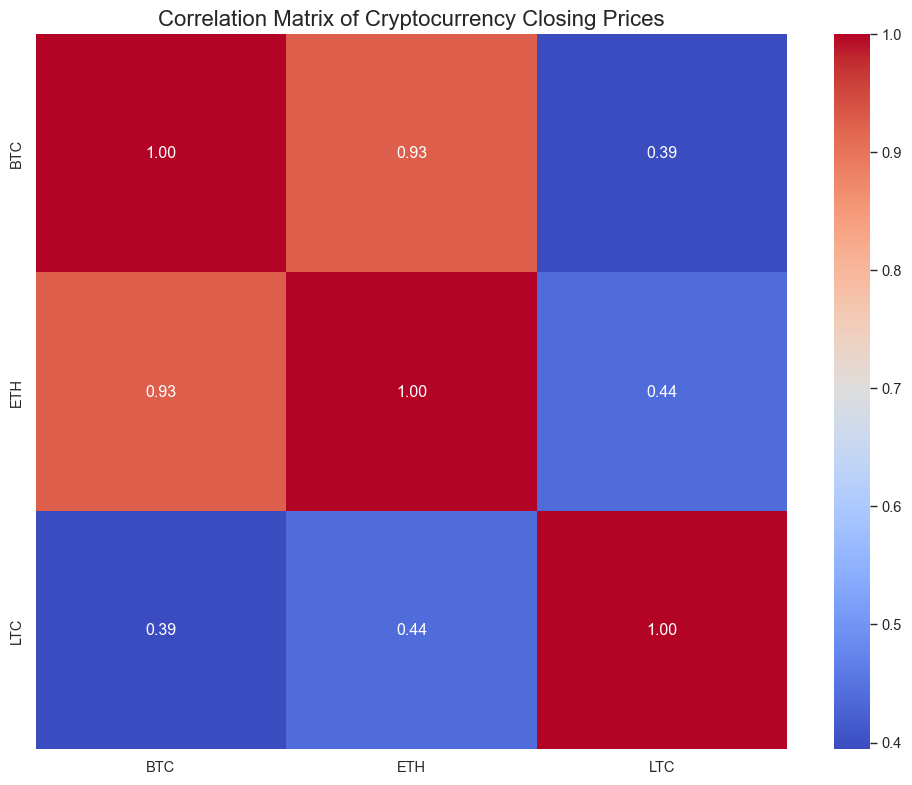

In [39]:
eda.plot_crypto_price_correlations()

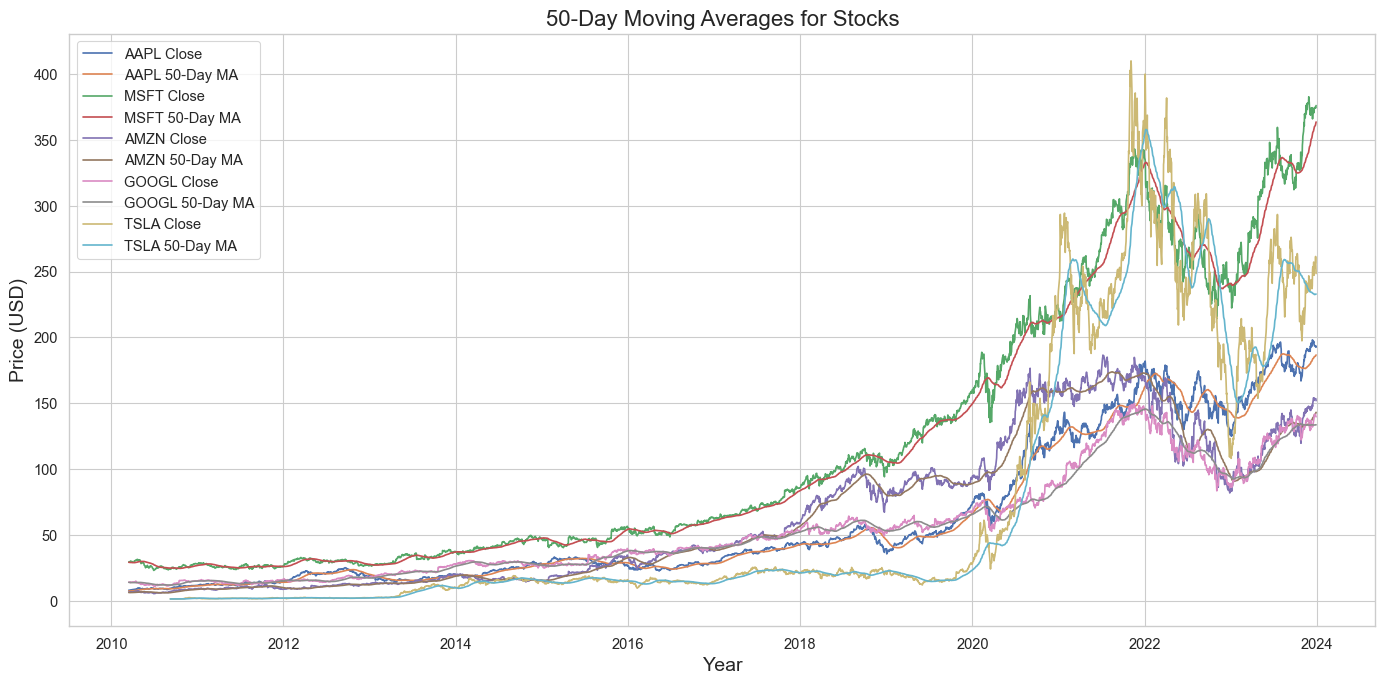

In [40]:
eda.plot_moving_averages()

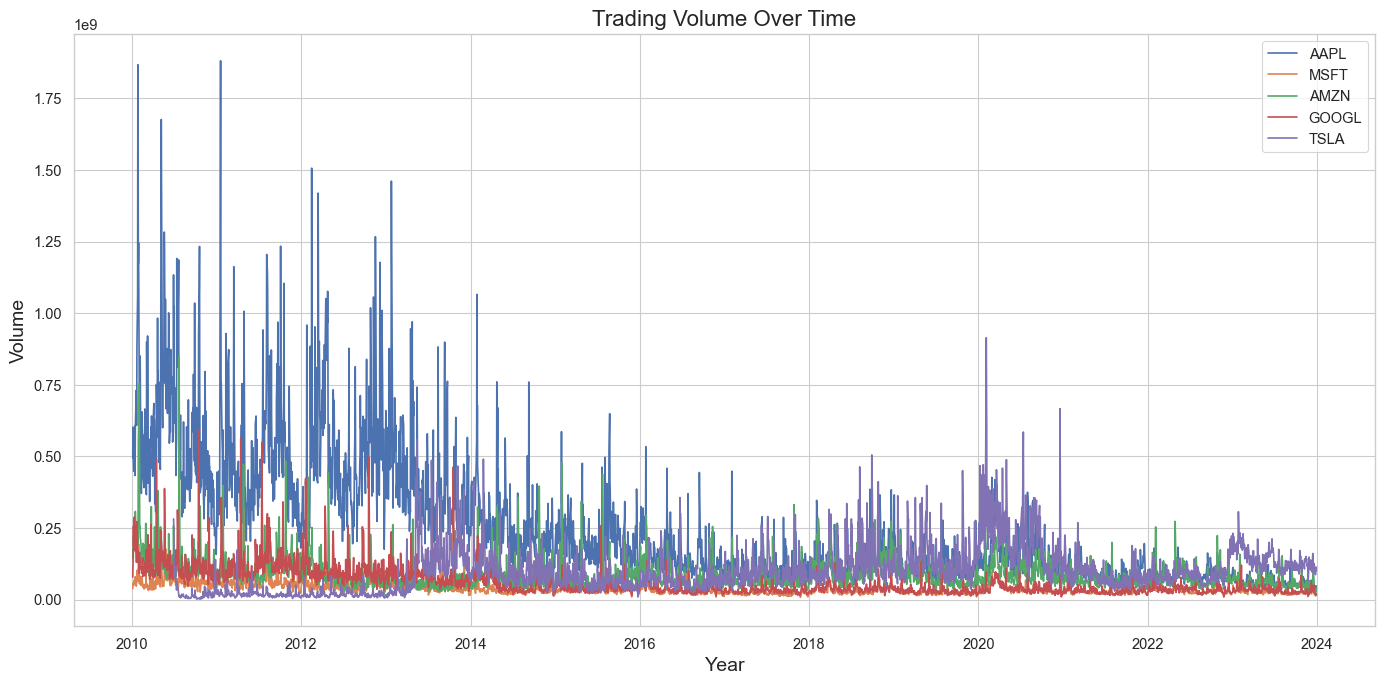

In [41]:
eda.plot_volume_trends()

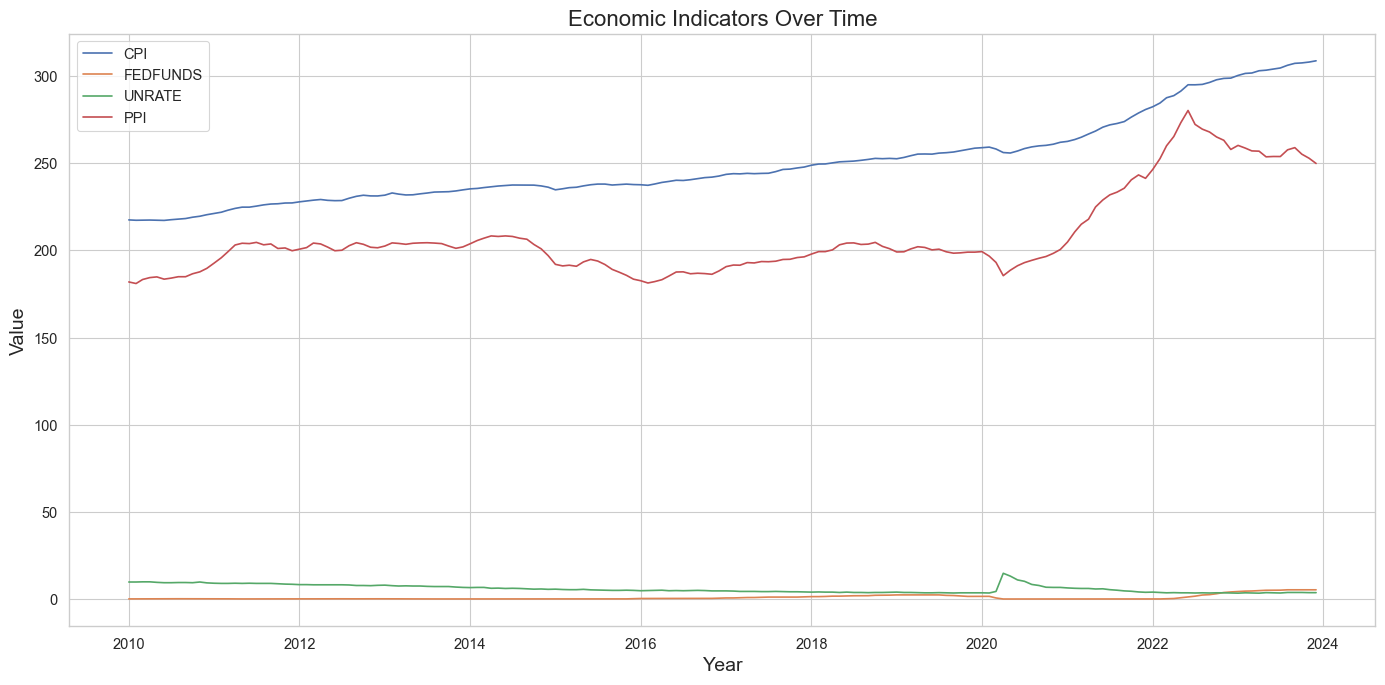

In [42]:
eda.plot_economic_indicators()

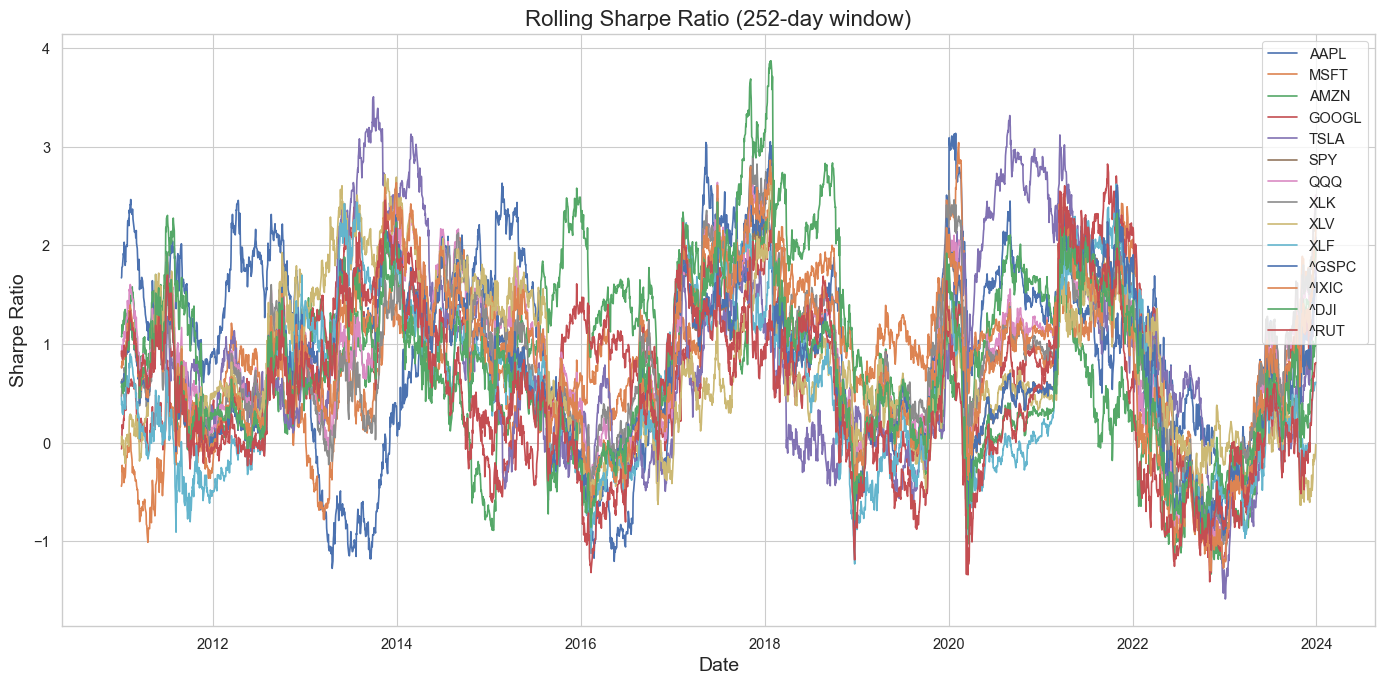

In [43]:
eda.plot_rolling_sharpe_ratios(eda.stocks + eda.etfs + eda.indices)

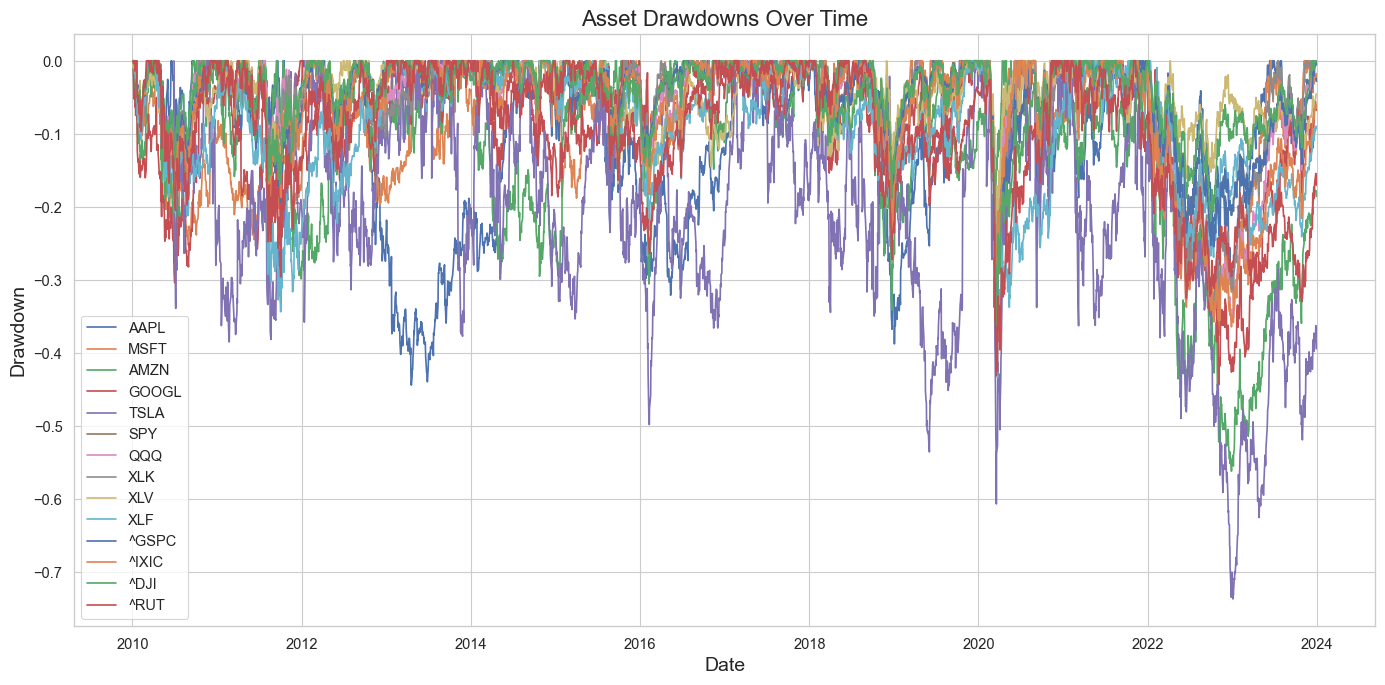

In [44]:
eda.plot_drawdowns(eda.stocks + eda.etfs + eda.indices)